In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import csv 
import pandas as pd
from pathlib import Path

In [2]:
result_path = os.path.join("outputs", "2024-12-18", "13-42-52")
result_path = "outputs"
with open(os.path.join(result_path, "lightning_logs", "metrics.csv")) as f: 
    logs = pd.read_csv( f )

epochs = logs['epoch'][1::2]

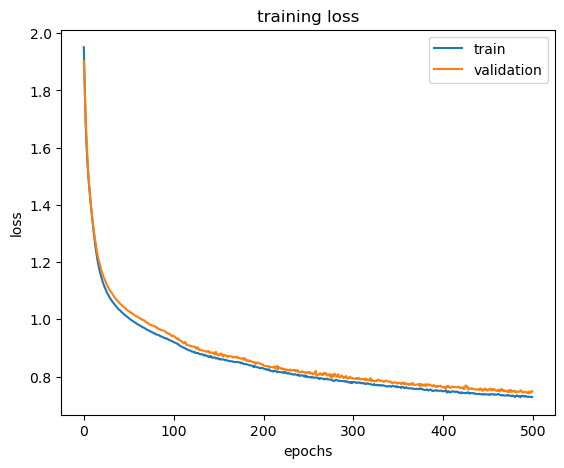

In [3]:
t_loss = logs['train_loss'][~np.isnan(np.array(logs['train_loss']))]
v_loss = logs['val_loss'][~np.isnan(np.array(logs['val_loss']))]

# trim = 100
# t_loss = t_loss[:trim]
# v_loss = v_loss[:trim]

plt.figure(figsize=(14,5)) 
plt.subplot(1,2,1)
plt.plot(np.arange(0, len(t_loss), 1), t_loss, label='train')
plt.plot(np.arange(0, len(v_loss), 1), v_loss, label='validation')
# plt.legend(["train", "val"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("training loss")
plt.legend()


In [4]:
logs

,val_loss,model params mean,val_ae_loss,epoch,step,val_data_loss,train_data_loss,train_ae_loss,train_loss
0,1.903240,0.000104,0.557849,0,64,0.982977,NaN,NaN,NaN
1,NaN,0.000057,NaN,0,64,NaN,0.990525,1.018287,1.950871
2,1.809321,0.000197,0.647787,1,129,0.951560,NaN,NaN,NaN
3,NaN,0.000149,NaN,1,129,NaN,0.935714,0.917379,1.822644
4,1.717475,0.000330,0.393589,2,194,0.920477,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
995,NaN,0.003280,NaN,497,32369,NaN,0.671173,0.054714,0.729636
996,0.744917,0.003282,0.013101,498,32434,0.671102,NaN,NaN,NaN
997,NaN,0.003281,NaN,498,32434,NaN,0.670144,0.052882,0.728588
998,0.749475,0.003281,0.013429,499,32499,0.675675,NaN,NaN,NaN


In [5]:
np.array(logs['model params mean'][0:10:2] )

array([0.00010365, 0.00019726, 0.00033011, 0.00047802, 0.00061748])

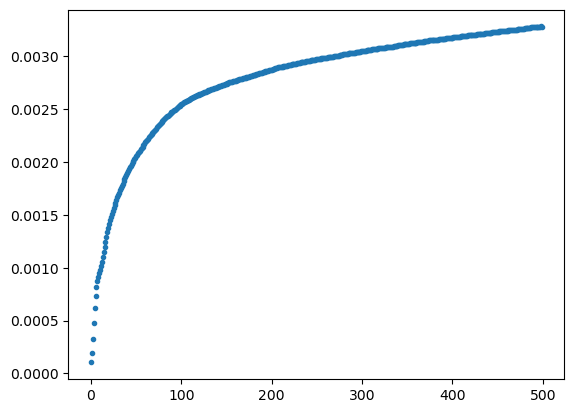

In [6]:
plt.plot(np.array(logs['model params mean'][0::2]), '.')

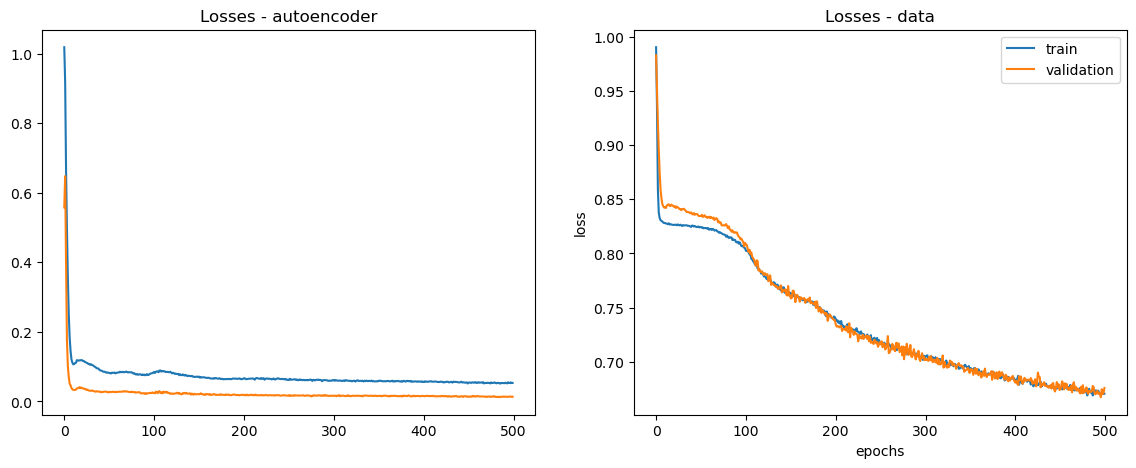

In [7]:
t_loss_ae = logs['train_ae_loss'][~np.isnan(np.array(logs['train_ae_loss']))]
v_loss_ae = logs['val_ae_loss'][~np.isnan(np.array(logs['val_ae_loss']))]

t_loss_data = logs['train_data_loss'][~np.isnan(np.array(logs['train_data_loss']))]
v_loss_data = logs['val_data_loss'][~np.isnan(np.array(logs['val_data_loss']))]

# trim = 100
# t_loss_ae = t_loss_ae[:trim]
# v_loss_ae = v_loss_ae[:trim]
# t_loss_data = t_loss_data[:trim]
# v_loss_data = v_loss_data[:trim]

plt.figure(figsize=(14,5)) 
plt.subplot(1,2,1)
plt.plot(np.arange(0, len(t_loss_ae), 1), t_loss_ae, label='train')
plt.plot(np.arange(0, len(v_loss_ae), 1), v_loss_ae, label='validation')
plt.title("Losses - autoencoder")
plt.subplot(1,2,2)
plt.plot(np.arange(0, len(t_loss_data), 1), t_loss_data, label='train')
plt.plot(np.arange(0, len(v_loss_data), 1), v_loss_data, label='validation')
# plt.legend(["train", "val"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Losses - data")
plt.legend()

# open a config

In [17]:
import hydra
from omegaconf import OmegaConf

In [18]:
config_path = Path(result_path, ".hydra")
with hydra.initialize(config_path=str(config_path), version_base="1.3"):
    cfg = hydra.compose("config")

# open test dataset config 

In [26]:
datamodule_config_path = Path(
    "config", "dataset", "test_dataset.yaml"
)
data_conf = OmegaConf.load(datamodule_config_path)
config_file = Path(
                data_conf.datafolder, 
                data_conf.subject_name, data_conf.orientation, data_conf.electrode_montage, data_conf.source_sampling, "simu",
                data_conf.simu_name, f"{data_conf.simu_name}{data_conf.source_sampling}_config.json"
)        
data_conf.update({'config_file': config_file})
# update the datamodule config with the dataset config, keeping only the keys that are in the dataset_kw
scaler_type = cfg.datamodule.dataset_kw.scaler_type
cfg.datamodule.update({"dataset_kw":{k:data_conf[k] for k in cfg.datamodule.dataset_kw.keys()}})
cfg.datamodule.dataset_kw.update({"scaler_type":scaler_type})

In [23]:
import contrib.eeg.data

In [27]:
dm = hydra.utils.call(cfg.datamodule)
dm.setup("test")
val_dl =  dm.test_dataloader()
val_ds = val_dl.dataset

--- only 22 available ---


# load model

In [ ]:
from contrib.eeg.autoencoder import autoencoder_pl as net
from contrib.eeg.models import PhiPriorCNN, EsiBaseObsCost, EsiGradSolver, RearrangedConvLstmGradModel, LearnGD
from contrib.eeg.models import Cosine, CosineReshape, MSE, MAE
from contrib.eeg.utils_eeg import load_fwd
import torch

In [ ]:
prior_cost = PhiPriorCNN(
    cost_fn = CosineReshape(),
    pretrained_model_path = None, 
    fixed=False, 
    n_sources=1284, 
    hidden_dim=128
)

fwd_name= 'fwd_ico3-fwd.fif'
head_model_dict = {
    "subject_name": "fsaverage",
    "orientation": "constrained", 
    "electrode_montage": "standard_1020", 
    "source_sampling": 'ico3' ,
}
fwd = load_fwd(
    datafolder=cfg.dataset.datafolder, 
    head_model_dict=head_model_dict, 
    fwd_name=fwd_name, 
    scaler_type=cfg.datamodule.dataset_kw.scaler_type)
    
obs_cost = EsiBaseObsCost(
    cost_fn = CosineReshape(),
    forward_obj=fwd
)

grad_mod = RearrangedConvLstmGradModel(
    dim_in = cfg.dataset.n_sources, 
    dim_hidden = 48,
)
solver = EsiGradSolver(
    prior_cost = prior_cost, obs_cost=obs_cost, grad_mod=grad_mod,
    n_step=10, lr_grad=1e-2,
    obs_ponde=1, prior_ponde=1, init_type='zeros', 
    fwd = fwd
)

Reading forward solution from /home/reynaudsarah/Documents/Data/simulation/fsaverage/constrained/standard_1020/ico3/model/fwd_ico3-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (1284 sources, 90 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [ ]:
model = LearnGD(solver, opt_fn=None, loss_fn=CosineReshape() )

In [ ]:
# get net parameters for the trained model and instantiate the model
# net_parameters = OmegaConf.to_container(cfg.model.net, resolve=True)
# net_parameters = {k:v for k,v in net_parameters.items() if k!='_target_'}
# model = net(**net_parameters) 

# load the trained model from the checkpoint
ckpt_name = "best_ckpt.ckpt" #chekpoint to load
ckpt_path = Path(result_path, "lightning_logs", "checkpoints", ckpt_name)

loaded_model = torch.load(ckpt_path,map_location=torch.device('cpu'))['state_dict']
model.load_state_dict(loaded_model)
model.eval() # set the model to evaluation mode

LearnGD(
  (solver): EsiGradSolver(
    (prior_cost): PhiPriorCNN(
      (cost_fn): CosineReshape()
      (model): autoencoder_pl(
        (model): autoencoder(
          (Encode_Conv): Conv1d(1284, 128, kernel_size=(1,), stride=(1,), padding=same, bias=False)
          (Encode_ReLU): ReLU()
          (Code_Conv1_0): Conv1d(128, 128, kernel_size=(1,), stride=(1,), padding=same, bias=False)
          (Decode_Conv): Conv1d(128, 1284, kernel_size=(1,), stride=(1,), padding=same, bias=False)
          (Decode_ReLU): ReLU()
        )
      )
    )
    (obs_cost): EsiBaseObsCost(
      (cost_fn): CosineReshape()
    )
    (grad_mod): RearrangedConvLstmGradModel(
      (gates): Conv2d(1332, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_out): Conv2d(48, 1284, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.1, inplace=False)
      (down): Identity()
      (up): Identity()
    )
  )
  (loss_fn): CosineReshape()
)

# check results

In [ ]:
k = 0
eeg, src = val_ds[k]

In [ ]:
eeg.min(), eeg.max(), src.min(), src.max()

(tensor(-1.), tensor(0.9794), tensor(0.), tensor(0.0054))

In [ ]:
src_out = model(next(iter(dm.test_dataloader()))).squeeze(0).detach().numpy()[0]

In [ ]:
src_out.min(), src_out.max()

(0.0, 7763970.0)

(-0.5, 255.5, 1283.5, -0.5)

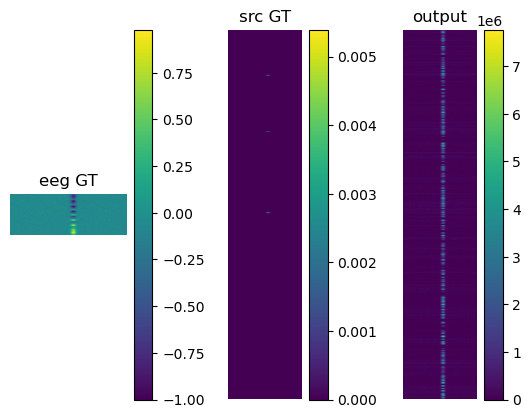

In [ ]:
plt.figure()
plt.subplot(131)
plt.imshow(eeg)
plt.colorbar() 
plt.title("eeg GT")
plt.axis('off')
plt.subplot(132)
plt.imshow(src)
plt.colorbar()
plt.title("src GT")
plt.axis('off')
plt.subplot(133)
plt.imshow(src_out)
plt.colorbar()
plt.title("output")
plt.axis('off')

In [ ]:
mse = np.mean((src.numpy() - src_out)**2)
normalised_mse = np.mean((src.numpy() / np.abs(src.numpy()).max() - src_out / np.abs(src_out).max())**2)
mse, normalised_mse

(241629100000.0, 0.0039581032)

In [ ]:
src_out.max(), src_out.min(), src.max(), src.min()

(7763970.0, 0.0, tensor(0.0054), tensor(0.))